<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/AutoencoderBasico_Kaggle_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [3]:
import PIL
import cv2
import os

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

## Descarga de Datos

Nos descargamos las imágenes con un ancho de 256 de ancho. Vamos a ir escalando a 64, 128 y 256. Lo haremos con cv2.resize()

### Kaggle

**Descargamos un dataset de kaggle para aumentar el número de imágenes de prueba**

Tiene las siguientes clases:

*   0 - No DR
*   1 - Mild
*   2 - Moderate
*   3 - Severe
*   4 - Proliferative DR


A nosotros nos intersan las de la clase 0. 







In [77]:
! pip install -q kaggle

In [78]:
from google.colab import files

In [79]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"diegorudiezgomez","key":"a97ea3f0837ef30e1012d50ea0d74929"}'}

In [80]:
! mkdir ~/.kaggle

In [81]:
! cp kaggle.json ~/.kaggle/

In [83]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [86]:
%%time
! kaggle competitions download -c 'aptos2019-blindness-detection'

100% 9.50G/9.51G [02:13<00:00, 149MB/s]
100% 9.51G/9.51G [02:13<00:00, 76.7MB/s]


In [89]:
!unzip -qq aptos2019-blindness-detection.zip -d 'datasetKaggle'

In [ ]:
datasetKaggle = 'datasetKaggle'

In [ ]:
imgTrain = os.listdir(datasetKaggle + '/train_images')

In [ ]:
datasetKaggle + '/train_images/' + imgTrain[0]

'datasetKaggle/train_images/300305ce82d2.png'

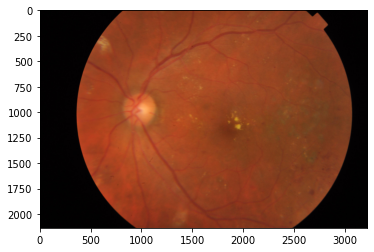

In [120]:
image = cv2.imread(datasetKaggle + '/train_images/' + imgTrain[0])
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [ ]:
df_trainKaggle = pd.read_csv(datasetKaggle + '/train.csv')

In [ ]:
df_trainKaggle['diagnosis'].value_counts() #1805 imágenes sanas

0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64

### Reto

**Ahora las del reto que hemos utilizado siempre.**

In [1]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-23 09:35:22 URL:https://uc861a1b439866155523f665bbe8.dl.dropboxusercontent.com/cd/0/inline2/BnuH9zPsrV60iT3zp1RjLZrbOQBl2tzMfSOzu32jLAgj_JIVWj6qcKo-UnX_IYc-FZrgExc9d0hyrNDab2ebeia8wiBHdMBaWVrfDNKhIGclDvXJZpGiPKXia2-PfdBgNleJX-4pmIDgCkQbIh83_-NIPVzzF8IycTq0XcydcEY-ohYzLy8HyKxYE_lcD-GyhUgM_g9vkSURdRsJiCdTdVlxcz_5JVEGb3OCokcqCfzv6vw639sdFDp1S_VnSOZpFCzEgPncVG54I-1aICKz32N5zNzcSyXReCFnobM7YX05Yyfcg638RSexeIKrTAmBtsaFFSotAlpvvVmBTymcu5uV1MY-KWrRfkC2SQazcONLumUxY2ewAE20uDzx64xggKBnm3SfaXfHhq0Zo6T7xndkN-Jf1sHKkzUK7uVICdl6Ng/file [138777773/138777773] -> "train.zip" [1]
2022-06-23 09:35:26 URL:https://uc092b79491408d2aaa1bed8e211.dl.dropboxusercontent.com/cd/0/inline2/Bnu3OSy_DSOW1hwiDz83dNiiWfeRoZKcJCgSIs2LJFQdIXJHiP1a1oNqCum3pxrFFLd6H4PhLhrIqpLYURDN-QxY2OIuKavqEHvxQK5Ms0CINj13Jk82uEF57HTTQ2023fTqb2Jib3vOPadJc2LmsALnZJvSvR2vDgePrxxTm_6JaNAH7tvexN8MQgG0t0DNwVe5q-Dw-PYeJar59zEip81q4oSZVzkbXvIhquVAg_2-wNrTp_LyZt4f2GOZLXQGhsGW4YnnCd01tzmsMgmthFOiD3pMNRG3VAQzHdz4yibsnXcuSBkbY2J_8ELcrYmgPh-

In [2]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [103]:
def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

    
def load_ben_color(path, sigmaX=10):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted(image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

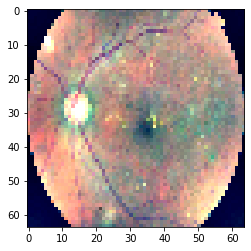

In [108]:
img = load_ben_color(datasetKaggle + '/train_images/' + imgTrain[0], 10)
plt.imshow(img)

In [112]:
df_trainKaggle

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


## Preparación de Datos

In [7]:
IMG_SIZE = 64

### Datos Kaggle

In [ ]:
import shutil

def getNpArrayKaggle(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['id_code'], df['diagnosis']):
    image = load_ben_color(pathO + '/' + str(id) + '.png')
    # image = cv2.imread(pathO + '/' + str(id) + '.png')
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [118]:
normalKaggle, enfermedadKaggle = getNpArrayKaggle(df_trainKaggle, datasetKaggle + '/train_images')

In [119]:
normalKaggle.shape

(1805, 64, 64, 3)

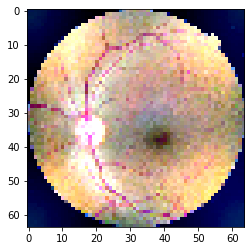

In [121]:
plt.imshow(normalKaggle[0])

### Datos Reto (el mismo de siempre)


In [5]:
import shutil

def getNpArray(df, pathO):
  normal, enfermedad = [], []
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    image = cv2.imread(pathO + '/' + str(id) + '.png')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    if(int(enf)==0):
      normal.append(np.asarray(image))
    else:
      enfermedad.append(np.asarray(image))
  return np.array(normal), np.array(enfermedad)

In [4]:
trainPath = 'Training_Set_Pre/'
testPath  = 'Test_Set_Pre/'
valPath  =  'Evaluation_Set_Pre/'

In [6]:
df_train = pd.read_csv(trainPath + '/train.csv')
df_test = pd.read_csv(testPath + '/test.csv')
df_val = pd.read_csv(valPath + '/val.csv')

In [8]:
normalTrain, enfermedadTrain = getNpArray(df_train, trainPath + 'Training/')
normalTest, enfermedadTest = getNpArray(df_test, testPath + 'Test/')
normalVal, enfermedadVal = getNpArray(df_val, valPath + 'Validation/')

In [9]:
normalTrain.shape

(401, 64, 64, 3)

In [10]:
normalTest.shape

(134, 64, 64, 3)

Ya la tenemos reescalada a la medida deseada:

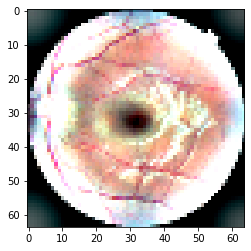

In [11]:
plt.imshow(normalTrain[0])

## Autoencoder

In [12]:
input_img = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))

### Encoder

In [13]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
# Capa de max pooling con filtro de tamaño 2x2 y aplicando padding
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

### Decoder

In [14]:
# Capa convolucional con 32 filtros de tamaño 3x3 seguida de una función de activación relu y aplicando padding
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
 # Capa de upsampling con filtro de tamaño 2x2 y aplicando padding
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [15]:
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [16]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248  

### Entrenamiento

In [122]:
dataNormalAll = np.concatenate([normalTrain, normalKaggle])

In [123]:
dataNormalAll.shape

(2206, 64, 64, 3)

In [124]:
autoencoder.fit(dataNormalAll, dataNormalAll,
                epochs=50,
                batch_size=128,
                validation_data=(normalVal, normalVal))

Epoch 1/50
18/18 [==============================] - 1s 77ms/step - loss: -25675.3809 - val_loss: -37209.1641
Epoch 2/50
18/18 [==============================] - 1s 60ms/step - loss: -26697.7480 - val_loss: -37660.3086
Epoch 3/50
18/18 [==============================] - 1s 60ms/step - loss: -27683.9453 - val_loss: -40421.5000
Epoch 4/50
18/18 [==============================] - 1s 61ms/step - loss: -28681.6777 - val_loss: -42312.2148
Epoch 5/50
18/18 [==============================] - 1s 61ms/step - loss: -29705.1777 - val_loss: -43626.1797
Epoch 6/50
18/18 [==============================] - 1s 61ms/step - loss: -30750.0059 - val_loss: -43222.8633
Epoch 7/50
18/18 [==============================] - 1s 61ms/step - loss: -31812.6895 - val_loss: -44212.4023
Epoch 8/50
18/18 [==============================] - 1s 61ms/step - loss: -32890.8477 - val_loss: -47592.3203
Epoch 9/50
18/18 [==============================] - 1s 61ms/step - loss: -33989.6250 - val_loss: -50294.9375
Epoch 10/50
18/18 [

### Pruebas

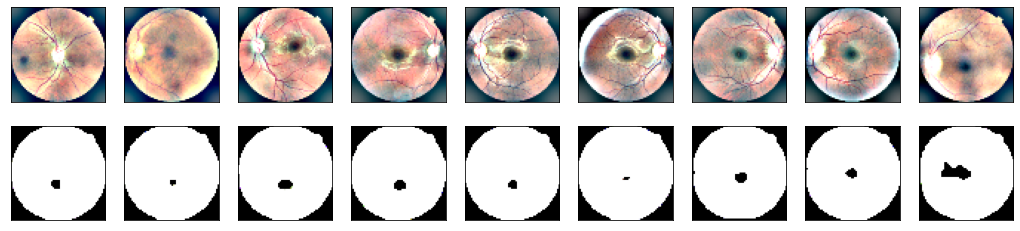

In [125]:
decoded_imgs = autoencoder.predict(normalTrain)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    ax = plt.subplot(2, n, i)
    plt.imshow(normalTest[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(IMG_SIZE, IMG_SIZE,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

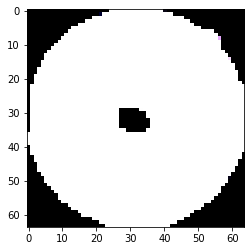

In [126]:
plt.imshow(decoded_imgs[0])

## Diferente Arquitectura

https://towardsdatascience.com/auto-encoder-what-is-it-and-what-is-it-used-for-part-1-3e5c6f017726

In [127]:
import numpy as np
from tensorflow import keras

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras import optimizers
from tensorflow.keras.optimizers import Adam

In [131]:
autoencoder = Sequential()
autoencoder.add(Dense(3, activation='elu', input_shape=(64,64,3)))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(10,    activation='linear', name="bottleneck"))
autoencoder.add(Dense(64,  activation='elu'))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(3,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

trained_model = autoencoder.fit(dataNormalAll, dataNormalAll, batch_size=1024, epochs=60, verbose=1, validation_data=(normalVal, normalVal))

Epoch 1/60
3/3 [==============================] - 3s 460ms/step - loss: 25394.0293 - val_loss: 29292.8965
Epoch 2/60
3/3 [==============================] - 1s 358ms/step - loss: 25281.3906 - val_loss: 29292.6777
Epoch 3/60
3/3 [==============================] - 1s 355ms/step - loss: 25281.2402 - val_loss: 29292.6484
Epoch 4/60
3/3 [==============================] - 1s 355ms/step - loss: 25281.2207 - val_loss: 29292.6367
Epoch 5/60
3/3 [==============================] - 1s 355ms/step - loss: 25281.2109 - val_loss: 29292.6289
Epoch 6/60
3/3 [==============================] - 1s 356ms/step - loss: 25281.2031 - val_loss: 29292.6230
Epoch 7/60
3/3 [==============================] - 1s 353ms/step - loss: 25281.2012 - val_loss: 29292.6211
Epoch 8/60
3/3 [==============================] - 1s 355ms/step - loss: 25281.1992 - val_loss: 29292.6172
Epoch 9/60
3/3 [==============================] - 1s 355ms/step - loss: 25281.1953 - val_loss: 29292.6172
Epoch 10/60
3/3 [=============================

In [80]:
encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)
encoded_data = encoder.predict(normalTrain)  # bottleneck representation
decoded_output = autoencoder.predict(normalTrain)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

In [132]:
predicts = autoencoder.predict(normalTest)

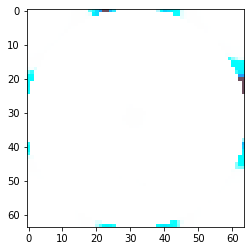

In [133]:
plt.imshow(predicts[4])

## Otra alternativa

In [134]:
model = keras.Sequential(
    [
        layers.Input(shape=(normalTrain.shape[1], normalTrain.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=64, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 32, 32)            14368     
                                                                 
 dropout_14 (Dropout)        (None, 32, 32)            0         
                                                                 
 conv1d_15 (Conv1D)          (None, 16, 16)            3600      
                                                                 
 conv1d_transpose_20 (Conv1D  (None, 32, 16)           1808      
 Transpose)                                                      
                                                                 
 dropout_15 (Dropout)        (None, 32, 16)            0         
                                                                 
 conv1d_transpose_21 (Conv1D  (None, 64, 32)           3616      
 Transpose)                                           

In [135]:
model.fit(
    normalTrain,
    normalTrain,
    epochs=50,
    batch_size=128,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50


ValueError: ignored

## Otra arquitectura diferente

https://medium.com/analytics-vidhya/image-anomaly-detection-using-autoencoders-ae937c7fd2d1

In [136]:
inputs = tf.keras.Input(shape=(64, 64, 3), name='input_layer')
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)
#Decoder
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)
# output
outputs = tf.keras.layers.Conv2DTranspose(3, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)

In [137]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy')

In [138]:
autoencoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 64, 64, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 64, 64, 32)       128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 32, 32, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 32, 32, 64)       256       
 tion)                                                     

In [139]:
hist=autoencoder.fit(dataNormalAll, dataNormalAll,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(normalVal, normalVal)
                )

Epoch 1/50
18/18 [==============================] - 3s 77ms/step - loss: -108.0760 - val_loss: -2441.9663
Epoch 2/50
18/18 [==============================] - 1s 61ms/step - loss: -295.9022 - val_loss: -3752.5168
Epoch 3/50
18/18 [==============================] - 1s 61ms/step - loss: -479.3603 - val_loss: -4810.1230
Epoch 4/50
18/18 [==============================] - 1s 61ms/step - loss: -671.8050 - val_loss: -6296.5293
Epoch 5/50
18/18 [==============================] - 1s 61ms/step - loss: -883.6248 - val_loss: -7426.8838
Epoch 6/50
18/18 [==============================] - 1s 61ms/step - loss: -1134.9807 - val_loss: -9070.3848
Epoch 7/50
18/18 [==============================] - 1s 61ms/step - loss: -1432.9612 - val_loss: -8770.2119
Epoch 8/50
18/18 [==============================] - 1s 61ms/step - loss: -1752.0444 - val_loss: -8416.0010
Epoch 9/50
18/18 [==============================] - 1s 61ms/step - loss: -2077.1265 - val_loss: -8587.4717
Epoch 10/50
18/18 [=======================

In [140]:
predicts = autoencoder.predict(normalTest)

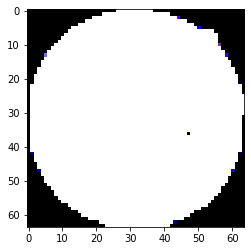

In [144]:
plt.imshow(predicts[6])

In [142]:
predicts = autoencoder.predict(enfermedadTest)

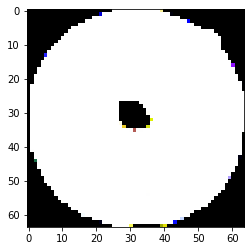

In [145]:
plt.imshow(predicts[70])